## 1.- Introduction

Explaining the output of a deep network remains a challenge.   In the case of an image classifier, one type of explanation is to identify pixels thatstrongly  influence  the  final  decision.  A  start-ing point for this strategy is the gradient of theclass score function with respect to the input im-age.  This gradient can be interpreted as asensi-tivity map, and there are several techniques thatelaborate on this basic idea.   This paper makestwo contributions: it introduces SMOOTHGRAD


SMOOTH-GRAD,  that  in  practice  tends  to  reduce  visual  noise,  andalso  can  be  combined  with  other  sensitivity  map  algo-rithms.  The core idea is to take an image of interest, sam-ple similar images by adding noise to the image, then takethe average of the resulting sensitivity maps for each sam-pled image.  We also find that the common regularizationtechnique of adding noise at training time (Bishop, 1995)has an additional “de-noising” effect on sensitivity maps.The two techniques (training with noise, and inferring withnoise) seem to have additive effect;  performing them to-gether yields the best results.

## VISUALIZING SALIENCY

This a notebook to test how does the package keras-vis performs and to check wether it is helpfull.


In [1]:
!nvidia-smi | grep "Tesla"

|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |


In [2]:
!pip install --upgrade tf-keras-vis tensorflow matplotlib

Requirement already up-to-date: tf-keras-vis in /usr/local/lib/python3.7/dist-packages (0.7.1)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


We will load a VGG16 model to test this package.

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As we can see inputs for model are in 224x224 so a sub/ super sampling will be needed.

Before and after: 
183 275 224 224 183 275 224 224


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


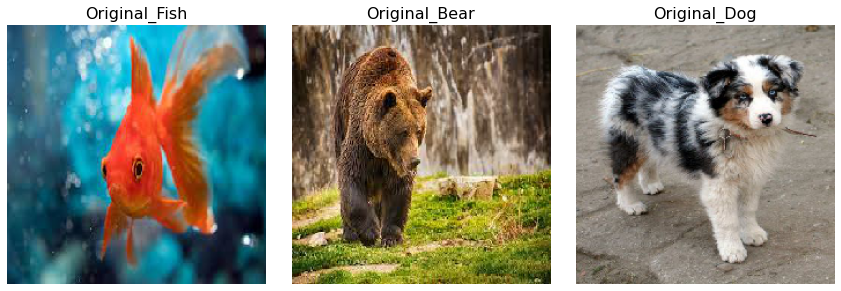

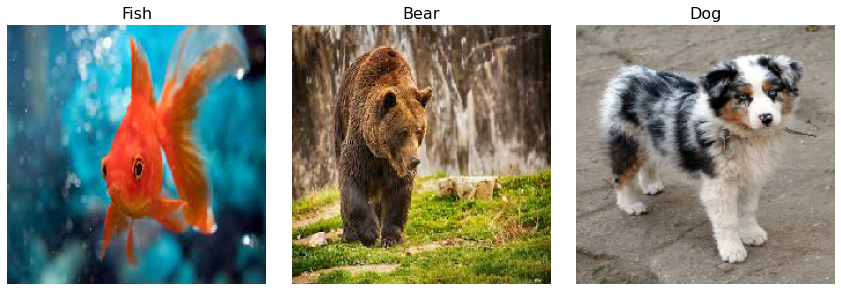

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Fish', 'Bear', 'Dog']

# Load images and Convert them to a Numpy array
img1 = load_img('images/fish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/dog.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

img11, img22, img33 = load_img('images/fish.jpg'), load_img('images/bear.jpg') , load_img('images/dog.jpg')
images_original = np.asarray([np.array(img11), np.array(img22), np.array(img33)])

print("Before and after: ")
print(img11.height, img11.width, img1.height, img1.width, img22.height, img22.width, img2.height, img2.width)

# Preparing input data for VGG16
X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(['Original_'+ title for title in image_titles]):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()



In [6]:
d = {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", "axolotl"], "30": ["n01641577", "bullfrog"], "31": ["n01644373", "tree_frog"], "32": ["n01644900", "tailed_frog"], "33": ["n01664065", "loggerhead"], "34": ["n01665541", "leatherback_turtle"], "35": ["n01667114", "mud_turtle"], "36": ["n01667778", "terrapin"], "37": ["n01669191", "box_turtle"], "38": ["n01675722", "banded_gecko"], "39": ["n01677366", "common_iguana"], "40": ["n01682714", "American_chameleon"], "41": ["n01685808", "whiptail"], "42": ["n01687978", "agama"], "43": ["n01688243", "frilled_lizard"], "44": ["n01689811", "alligator_lizard"], "45": ["n01692333", "Gila_monster"], "46": ["n01693334", "green_lizard"], "47": ["n01694178", "African_chameleon"], "48": ["n01695060", "Komodo_dragon"], "49": ["n01697457", "African_crocodile"], "50": ["n01698640", "American_alligator"], "51": ["n01704323", "triceratops"], "52": ["n01728572", "thunder_snake"], "53": ["n01728920", "ringneck_snake"], "54": ["n01729322", "hognose_snake"], "55": ["n01729977", "green_snake"], "56": ["n01734418", "king_snake"], "57": ["n01735189", "garter_snake"], "58": ["n01737021", "water_snake"], "59": ["n01739381", "vine_snake"], "60": ["n01740131", "night_snake"], "61": ["n01742172", "boa_constrictor"], "62": ["n01744401", "rock_python"], "63": ["n01748264", "Indian_cobra"], "64": ["n01749939", "green_mamba"], "65": ["n01751748", "sea_snake"], "66": ["n01753488", "horned_viper"], "67": ["n01755581", "diamondback"], "68": ["n01756291", "sidewinder"], "69": ["n01768244", "trilobite"], "70": ["n01770081", "harvestman"], "71": ["n01770393", "scorpion"], "72": ["n01773157", "black_and_gold_garden_spider"], "73": ["n01773549", "barn_spider"], "74": ["n01773797", "garden_spider"], "75": ["n01774384", "black_widow"], "76": ["n01774750", "tarantula"], "77": ["n01775062", "wolf_spider"], "78": ["n01776313", "tick"], "79": ["n01784675", "centipede"], "80": ["n01795545", "black_grouse"], "81": ["n01796340", "ptarmigan"], "82": ["n01797886", "ruffed_grouse"], "83": ["n01798484", "prairie_chicken"], "84": ["n01806143", "peacock"], "85": ["n01806567", "quail"], "86": ["n01807496", "partridge"], "87": ["n01817953", "African_grey"], "88": ["n01818515", "macaw"], "89": ["n01819313", "sulphur-crested_cockatoo"], "90": ["n01820546", "lorikeet"], "91": ["n01824575", "coucal"], "92": ["n01828970", "bee_eater"], "93": ["n01829413", "hornbill"], "94": ["n01833805", "hummingbird"], "95": ["n01843065", "jacamar"], "96": ["n01843383", "toucan"], "97": ["n01847000", "drake"], "98": ["n01855032", "red-breasted_merganser"], "99": ["n01855672", "goose"], "100": ["n01860187", "black_swan"], "101": ["n01871265", "tusker"], "102": ["n01872401", "echidna"], "103": ["n01873310", "platypus"], "104": ["n01877812", "wallaby"], "105": ["n01882714", "koala"], "106": ["n01883070", "wombat"], "107": ["n01910747", "jellyfish"], "108": ["n01914609", "sea_anemone"], "109": ["n01917289", "brain_coral"], "110": ["n01924916", "flatworm"], "111": ["n01930112", "nematode"], "112": ["n01943899", "conch"], "113": ["n01944390", "snail"], "114": ["n01945685", "slug"], "115": ["n01950731", "sea_slug"], "116": ["n01955084", "chiton"], "117": ["n01968897", "chambered_nautilus"], "118": ["n01978287", "Dungeness_crab"], "119": ["n01978455", "rock_crab"], "120": ["n01980166", "fiddler_crab"], "121": ["n01981276", "king_crab"], "122": ["n01983481", "American_lobster"], "123": ["n01984695", "spiny_lobster"], "124": ["n01985128", "crayfish"], "125": ["n01986214", "hermit_crab"], "126": ["n01990800", "isopod"], "127": ["n02002556", "white_stork"], "128": ["n02002724", "black_stork"], "129": ["n02006656", "spoonbill"], "130": ["n02007558", "flamingo"], "131": ["n02009229", "little_blue_heron"], "132": ["n02009912", "American_egret"], "133": ["n02011460", "bittern"], "134": ["n02012849", "crane"], "135": ["n02013706", "limpkin"], "136": ["n02017213", "European_gallinule"], "137": ["n02018207", "American_coot"], "138": ["n02018795", "bustard"], "139": ["n02025239", "ruddy_turnstone"], "140": ["n02027492", "red-backed_sandpiper"], "141": ["n02028035", "redshank"], "142": ["n02033041", "dowitcher"], "143": ["n02037110", "oystercatcher"], "144": ["n02051845", "pelican"], "145": ["n02056570", "king_penguin"], "146": ["n02058221", "albatross"], "147": ["n02066245", "grey_whale"], "148": ["n02071294", "killer_whale"], "149": ["n02074367", "dugong"], "150": ["n02077923", "sea_lion"], "151": ["n02085620", "Chihuahua"], "152": ["n02085782", "Japanese_spaniel"], "153": ["n02085936", "Maltese_dog"], "154": ["n02086079", "Pekinese"], "155": ["n02086240", "Shih-Tzu"], "156": ["n02086646", "Blenheim_spaniel"], "157": ["n02086910", "papillon"], "158": ["n02087046", "toy_terrier"], "159": ["n02087394", "Rhodesian_ridgeback"], "160": ["n02088094", "Afghan_hound"], "161": ["n02088238", "basset"], "162": ["n02088364", "beagle"], "163": ["n02088466", "bloodhound"], "164": ["n02088632", "bluetick"], "165": ["n02089078", "black-and-tan_coonhound"], "166": ["n02089867", "Walker_hound"], "167": ["n02089973", "English_foxhound"], "168": ["n02090379", "redbone"], "169": ["n02090622", "borzoi"], "170": ["n02090721", "Irish_wolfhound"], "171": ["n02091032", "Italian_greyhound"], "172": ["n02091134", "whippet"], "173": ["n02091244", "Ibizan_hound"], "174": ["n02091467", "Norwegian_elkhound"], "175": ["n02091635", "otterhound"], "176": ["n02091831", "Saluki"], "177": ["n02092002", "Scottish_deerhound"], "178": ["n02092339", "Weimaraner"], "179": ["n02093256", "Staffordshire_bullterrier"], "180": ["n02093428", "American_Staffordshire_terrier"], "181": ["n02093647", "Bedlington_terrier"], "182": ["n02093754", "Border_terrier"], "183": ["n02093859", "Kerry_blue_terrier"], "184": ["n02093991", "Irish_terrier"], "185": ["n02094114", "Norfolk_terrier"], "186": ["n02094258", "Norwich_terrier"], "187": ["n02094433", "Yorkshire_terrier"], "188": ["n02095314", "wire-haired_fox_terrier"], "189": ["n02095570", "Lakeland_terrier"], "190": ["n02095889", "Sealyham_terrier"], "191": ["n02096051", "Airedale"], "192": ["n02096177", "cairn"], "193": ["n02096294", "Australian_terrier"], "194": ["n02096437", "Dandie_Dinmont"], "195": ["n02096585", "Boston_bull"], "196": ["n02097047", "miniature_schnauzer"], "197": ["n02097130", "giant_schnauzer"], "198": ["n02097209", "standard_schnauzer"], "199": ["n02097298", "Scotch_terrier"], "200": ["n02097474", "Tibetan_terrier"], "201": ["n02097658", "silky_terrier"], "202": ["n02098105", "soft-coated_wheaten_terrier"], "203": ["n02098286", "West_Highland_white_terrier"], "204": ["n02098413", "Lhasa"], "205": ["n02099267", "flat-coated_retriever"], "206": ["n02099429", "curly-coated_retriever"], "207": ["n02099601", "golden_retriever"], "208": ["n02099712", "Labrador_retriever"], "209": ["n02099849", "Chesapeake_Bay_retriever"], "210": ["n02100236", "German_short-haired_pointer"], "211": ["n02100583", "vizsla"], "212": ["n02100735", "English_setter"], "213": ["n02100877", "Irish_setter"], "214": ["n02101006", "Gordon_setter"], "215": ["n02101388", "Brittany_spaniel"], "216": ["n02101556", "clumber"], "217": ["n02102040", "English_springer"], "218": ["n02102177", "Welsh_springer_spaniel"], "219": ["n02102318", "cocker_spaniel"], "220": ["n02102480", "Sussex_spaniel"], "221": ["n02102973", "Irish_water_spaniel"], "222": ["n02104029", "kuvasz"], "223": ["n02104365", "schipperke"], "224": ["n02105056", "groenendael"], "225": ["n02105162", "malinois"], "226": ["n02105251", "briard"], "227": ["n02105412", "kelpie"], "228": ["n02105505", "komondor"], "229": ["n02105641", "Old_English_sheepdog"], "230": ["n02105855", "Shetland_sheepdog"], "231": ["n02106030", "collie"], "232": ["n02106166", "Border_collie"], "233": ["n02106382", "Bouvier_des_Flandres"], "234": ["n02106550", "Rottweiler"], "235": ["n02106662", "German_shepherd"], "236": ["n02107142", "Doberman"], "237": ["n02107312", "miniature_pinscher"], "238": ["n02107574", "Greater_Swiss_Mountain_dog"], "239": ["n02107683", "Bernese_mountain_dog"], "240": ["n02107908", "Appenzeller"], "241": ["n02108000", "EntleBucher"], "242": ["n02108089", "boxer"], "243": ["n02108422", "bull_mastiff"], "244": ["n02108551", "Tibetan_mastiff"], "245": ["n02108915", "French_bulldog"], "246": ["n02109047", "Great_Dane"], "247": ["n02109525", "Saint_Bernard"], "248": ["n02109961", "Eskimo_dog"], "249": ["n02110063", "malamute"], "250": ["n02110185", "Siberian_husky"], "251": ["n02110341", "dalmatian"], "252": ["n02110627", "affenpinscher"], "253": ["n02110806", "basenji"], "254": ["n02110958", "pug"], "255": ["n02111129", "Leonberg"], "256": ["n02111277", "Newfoundland"], "257": ["n02111500", "Great_Pyrenees"], "258": ["n02111889", "Samoyed"], "259": ["n02112018", "Pomeranian"], "260": ["n02112137", "chow"], "261": ["n02112350", "keeshond"], "262": ["n02112706", "Brabancon_griffon"], "263": ["n02113023", "Pembroke"], "264": ["n02113186", "Cardigan"], "265": ["n02113624", "toy_poodle"], "266": ["n02113712", "miniature_poodle"], "267": ["n02113799", "standard_poodle"], "268": ["n02113978", "Mexican_hairless"], "269": ["n02114367", "timber_wolf"], "270": ["n02114548", "white_wolf"], "271": ["n02114712", "red_wolf"], "272": ["n02114855", "coyote"], "273": ["n02115641", "dingo"], "274": ["n02115913", "dhole"], "275": ["n02116738", "African_hunting_dog"], "276": ["n02117135", "hyena"], "277": ["n02119022", "red_fox"], "278": ["n02119789", "kit_fox"], "279": ["n02120079", "Arctic_fox"], "280": ["n02120505", "grey_fox"], "281": ["n02123045", "tabby"], "282": ["n02123159", "tiger_cat"], "283": ["n02123394", "Persian_cat"], "284": ["n02123597", "Siamese_cat"], "285": ["n02124075", "Egyptian_cat"], "286": ["n02125311", "cougar"], "287": ["n02127052", "lynx"], "288": ["n02128385", "leopard"], "289": ["n02128757", "snow_leopard"], "290": ["n02128925", "jaguar"], "291": ["n02129165", "lion"], "292": ["n02129604", "tiger"], "293": ["n02130308", "cheetah"], "294": ["n02132136", "brown_bear"], "295": ["n02133161", "American_black_bear"], "296": ["n02134084", "ice_bear"], "297": ["n02134418", "sloth_bear"], "298": ["n02137549", "mongoose"], "299": ["n02138441", "meerkat"], "300": ["n02165105", "tiger_beetle"], "301": ["n02165456", "ladybug"], "302": ["n02167151", "ground_beetle"], "303": ["n02168699", "long-horned_beetle"], "304": ["n02169497", "leaf_beetle"], "305": ["n02172182", "dung_beetle"], "306": ["n02174001", "rhinoceros_beetle"], "307": ["n02177972", "weevil"], "308": ["n02190166", "fly"], "309": ["n02206856", "bee"], "310": ["n02219486", "ant"], "311": ["n02226429", "grasshopper"], "312": ["n02229544", "cricket"], "313": ["n02231487", "walking_stick"], "314": ["n02233338", "cockroach"], "315": ["n02236044", "mantis"], "316": ["n02256656", "cicada"], "317": ["n02259212", "leafhopper"], "318": ["n02264363", "lacewing"], "319": ["n02268443", "dragonfly"], "320": ["n02268853", "damselfly"], "321": ["n02276258", "admiral"], "322": ["n02277742", "ringlet"], "323": ["n02279972", "monarch"], "324": ["n02280649", "cabbage_butterfly"], "325": ["n02281406", "sulphur_butterfly"], "326": ["n02281787", "lycaenid"], "327": ["n02317335", "starfish"], "328": ["n02319095", "sea_urchin"], "329": ["n02321529", "sea_cucumber"], "330": ["n02325366", "wood_rabbit"], "331": ["n02326432", "hare"], "332": ["n02328150", "Angora"], "333": ["n02342885", "hamster"], "334": ["n02346627", "porcupine"], "335": ["n02356798", "fox_squirrel"], "336": ["n02361337", "marmot"], "337": ["n02363005", "beaver"], "338": ["n02364673", "guinea_pig"], "339": ["n02389026", "sorrel"], "340": ["n02391049", "zebra"], "341": ["n02395406", "hog"], "342": ["n02396427", "wild_boar"], "343": ["n02397096", "warthog"], "344": ["n02398521", "hippopotamus"], "345": ["n02403003", "ox"], "346": ["n02408429", "water_buffalo"], "347": ["n02410509", "bison"], "348": ["n02412080", "ram"], "349": ["n02415577", "bighorn"], "350": ["n02417914", "ibex"], "351": ["n02422106", "hartebeest"], "352": ["n02422699", "impala"], "353": ["n02423022", "gazelle"], "354": ["n02437312", "Arabian_camel"], "355": ["n02437616", "llama"], "356": ["n02441942", "weasel"], "357": ["n02442845", "mink"], "358": ["n02443114", "polecat"], "359": ["n02443484", "black-footed_ferret"], "360": ["n02444819", "otter"], "361": ["n02445715", "skunk"], "362": ["n02447366", "badger"], "363": ["n02454379", "armadillo"], "364": ["n02457408", "three-toed_sloth"], "365": ["n02480495", "orangutan"], "366": ["n02480855", "gorilla"], "367": ["n02481823", "chimpanzee"], "368": ["n02483362", "gibbon"], "369": ["n02483708", "siamang"], "370": ["n02484975", "guenon"], "371": ["n02486261", "patas"], "372": ["n02486410", "baboon"], "373": ["n02487347", "macaque"], "374": ["n02488291", "langur"], "375": ["n02488702", "colobus"], "376": ["n02489166", "proboscis_monkey"], "377": ["n02490219", "marmoset"], "378": ["n02492035", "capuchin"], "379": ["n02492660", "howler_monkey"], "380": ["n02493509", "titi"], "381": ["n02493793", "spider_monkey"], "382": ["n02494079", "squirrel_monkey"], "383": ["n02497673", "Madagascar_cat"], "384": ["n02500267", "indri"], "385": ["n02504013", "Indian_elephant"], "386": ["n02504458", "African_elephant"], "387": ["n02509815", "lesser_panda"], "388": ["n02510455", "giant_panda"], "389": ["n02514041", "barracouta"], "390": ["n02526121", "eel"], "391": ["n02536864", "coho"], "392": ["n02606052", "rock_beauty"], "393": ["n02607072", "anemone_fish"], "394": ["n02640242", "sturgeon"], "395": ["n02641379", "gar"], "396": ["n02643566", "lionfish"], "397": ["n02655020", "puffer"], "398": ["n02666196", "abacus"], "399": ["n02667093", "abaya"], "400": ["n02669723", "academic_gown"], "401": ["n02672831", "accordion"], "402": ["n02676566", "acoustic_guitar"], "403": ["n02687172", "aircraft_carrier"], "404": ["n02690373", "airliner"], "405": ["n02692877", "airship"], "406": ["n02699494", "altar"], "407": ["n02701002", "ambulance"], "408": ["n02704792", "amphibian"], "409": ["n02708093", "analog_clock"], "410": ["n02727426", "apiary"], "411": ["n02730930", "apron"], "412": ["n02747177", "ashcan"], "413": ["n02749479", "assault_rifle"], "414": ["n02769748", "backpack"], "415": ["n02776631", "bakery"], "416": ["n02777292", "balance_beam"], "417": ["n02782093", "balloon"], "418": ["n02783161", "ballpoint"], "419": ["n02786058", "Band_Aid"], "420": ["n02787622", "banjo"], "421": ["n02788148", "bannister"], "422": ["n02790996", "barbell"], "423": ["n02791124", "barber_chair"], "424": ["n02791270", "barbershop"], "425": ["n02793495", "barn"], "426": ["n02794156", "barometer"], "427": ["n02795169", "barrel"], "428": ["n02797295", "barrow"], "429": ["n02799071", "baseball"], "430": ["n02802426", "basketball"], "431": ["n02804414", "bassinet"], "432": ["n02804610", "bassoon"], "433": ["n02807133", "bathing_cap"], "434": ["n02808304", "bath_towel"], "435": ["n02808440", "bathtub"], "436": ["n02814533", "beach_wagon"], "437": ["n02814860", "beacon"], "438": ["n02815834", "beaker"], "439": ["n02817516", "bearskin"], "440": ["n02823428", "beer_bottle"], "441": ["n02823750", "beer_glass"], "442": ["n02825657", "bell_cote"], "443": ["n02834397", "bib"], "444": ["n02835271", "bicycle-built-for-two"], "445": ["n02837789", "bikini"], "446": ["n02840245", "binder"], "447": ["n02841315", "binoculars"], "448": ["n02843684", "birdhouse"], "449": ["n02859443", "boathouse"], "450": ["n02860847", "bobsled"], "451": ["n02865351", "bolo_tie"], "452": ["n02869837", "bonnet"], "453": ["n02870880", "bookcase"], "454": ["n02871525", "bookshop"], "455": ["n02877765", "bottlecap"], "456": ["n02879718", "bow"], "457": ["n02883205", "bow_tie"], "458": ["n02892201", "brass"], "459": ["n02892767", "brassiere"], "460": ["n02894605", "breakwater"], "461": ["n02895154", "breastplate"], "462": ["n02906734", "broom"], "463": ["n02909870", "bucket"], "464": ["n02910353", "buckle"], "465": ["n02916936", "bulletproof_vest"], "466": ["n02917067", "bullet_train"], "467": ["n02927161", "butcher_shop"], "468": ["n02930766", "cab"], "469": ["n02939185", "caldron"], "470": ["n02948072", "candle"], "471": ["n02950826", "cannon"], "472": ["n02951358", "canoe"], "473": ["n02951585", "can_opener"], "474": ["n02963159", "cardigan"], "475": ["n02965783", "car_mirror"], "476": ["n02966193", "carousel"], "477": ["n02966687", "carpenter's_kit"], "478": ["n02971356", "carton"], "479": ["n02974003", "car_wheel"], "480": ["n02977058", "cash_machine"], "481": ["n02978881", "cassette"], "482": ["n02979186", "cassette_player"], "483": ["n02980441", "castle"], "484": ["n02981792", "catamaran"], "485": ["n02988304", "CD_player"], "486": ["n02992211", "cello"], "487": ["n02992529", "cellular_telephone"], "488": ["n02999410", "chain"], "489": ["n03000134", "chainlink_fence"], "490": ["n03000247", "chain_mail"], "491": ["n03000684", "chain_saw"], "492": ["n03014705", "chest"], "493": ["n03016953", "chiffonier"], "494": ["n03017168", "chime"], "495": ["n03018349", "china_cabinet"], "496": ["n03026506", "Christmas_stocking"], "497": ["n03028079", "church"], "498": ["n03032252", "cinema"], "499": ["n03041632", "cleaver"], "500": ["n03042490", "cliff_dwelling"], "501": ["n03045698", "cloak"], "502": ["n03047690", "clog"], "503": ["n03062245", "cocktail_shaker"], "504": ["n03063599", "coffee_mug"], "505": ["n03063689", "coffeepot"], "506": ["n03065424", "coil"], "507": ["n03075370", "combination_lock"], "508": ["n03085013", "computer_keyboard"], "509": ["n03089624", "confectionery"], "510": ["n03095699", "container_ship"], "511": ["n03100240", "convertible"], "512": ["n03109150", "corkscrew"], "513": ["n03110669", "cornet"], "514": ["n03124043", "cowboy_boot"], "515": ["n03124170", "cowboy_hat"], "516": ["n03125729", "cradle"], "517": ["n03126707", "crane"], "518": ["n03127747", "crash_helmet"], "519": ["n03127925", "crate"], "520": ["n03131574", "crib"], "521": ["n03133878", "Crock_Pot"], "522": ["n03134739", "croquet_ball"], "523": ["n03141823", "crutch"], "524": ["n03146219", "cuirass"], "525": ["n03160309", "dam"], "526": ["n03179701", "desk"], "527": ["n03180011", "desktop_computer"], "528": ["n03187595", "dial_telephone"], "529": ["n03188531", "diaper"], "530": ["n03196217", "digital_clock"], "531": ["n03197337", "digital_watch"], "532": ["n03201208", "dining_table"], "533": ["n03207743", "dishrag"], "534": ["n03207941", "dishwasher"], "535": ["n03208938", "disk_brake"], "536": ["n03216828", "dock"], "537": ["n03218198", "dogsled"], "538": ["n03220513", "dome"], "539": ["n03223299", "doormat"], "540": ["n03240683", "drilling_platform"], "541": ["n03249569", "drum"], "542": ["n03250847", "drumstick"], "543": ["n03255030", "dumbbell"], "544": ["n03259280", "Dutch_oven"], "545": ["n03271574", "electric_fan"], "546": ["n03272010", "electric_guitar"], "547": ["n03272562", "electric_locomotive"], "548": ["n03290653", "entertainment_center"], "549": ["n03291819", "envelope"], "550": ["n03297495", "espresso_maker"], "551": ["n03314780", "face_powder"], "552": ["n03325584", "feather_boa"], "553": ["n03337140", "file"], "554": ["n03344393", "fireboat"], "555": ["n03345487", "fire_engine"], "556": ["n03347037", "fire_screen"], "557": ["n03355925", "flagpole"], "558": ["n03372029", "flute"], "559": ["n03376595", "folding_chair"], "560": ["n03379051", "football_helmet"], "561": ["n03384352", "forklift"], "562": ["n03388043", "fountain"], "563": ["n03388183", "fountain_pen"], "564": ["n03388549", "four-poster"], "565": ["n03393912", "freight_car"], "566": ["n03394916", "French_horn"], "567": ["n03400231", "frying_pan"], "568": ["n03404251", "fur_coat"], "569": ["n03417042", "garbage_truck"], "570": ["n03424325", "gasmask"], "571": ["n03425413", "gas_pump"], "572": ["n03443371", "goblet"], "573": ["n03444034", "go-kart"], "574": ["n03445777", "golf_ball"], "575": ["n03445924", "golfcart"], "576": ["n03447447", "gondola"], "577": ["n03447721", "gong"], "578": ["n03450230", "gown"], "579": ["n03452741", "grand_piano"], "580": ["n03457902", "greenhouse"], "581": ["n03459775", "grille"], "582": ["n03461385", "grocery_store"], "583": ["n03467068", "guillotine"], "584": ["n03476684", "hair_slide"], "585": ["n03476991", "hair_spray"], "586": ["n03478589", "half_track"], "587": ["n03481172", "hammer"], "588": ["n03482405", "hamper"], "589": ["n03483316", "hand_blower"], "590": ["n03485407", "hand-held_computer"], "591": ["n03485794", "handkerchief"], "592": ["n03492542", "hard_disc"], "593": ["n03494278", "harmonica"], "594": ["n03495258", "harp"], "595": ["n03496892", "harvester"], "596": ["n03498962", "hatchet"], "597": ["n03527444", "holster"], "598": ["n03529860", "home_theater"], "599": ["n03530642", "honeycomb"], "600": ["n03532672", "hook"], "601": ["n03534580", "hoopskirt"], "602": ["n03535780", "horizontal_bar"], "603": ["n03538406", "horse_cart"], "604": ["n03544143", "hourglass"], "605": ["n03584254", "iPod"], "606": ["n03584829", "iron"], "607": ["n03590841", "jack-o'-lantern"], "608": ["n03594734", "jean"], "609": ["n03594945", "jeep"], "610": ["n03595614", "jersey"], "611": ["n03598930", "jigsaw_puzzle"], "612": ["n03599486", "jinrikisha"], "613": ["n03602883", "joystick"], "614": ["n03617480", "kimono"], "615": ["n03623198", "knee_pad"], "616": ["n03627232", "knot"], "617": ["n03630383", "lab_coat"], "618": ["n03633091", "ladle"], "619": ["n03637318", "lampshade"], "620": ["n03642806", "laptop"], "621": ["n03649909", "lawn_mower"], "622": ["n03657121", "lens_cap"], "623": ["n03658185", "letter_opener"], "624": ["n03661043", "library"], "625": ["n03662601", "lifeboat"], "626": ["n03666591", "lighter"], "627": ["n03670208", "limousine"], "628": ["n03673027", "liner"], "629": ["n03676483", "lipstick"], "630": ["n03680355", "Loafer"], "631": ["n03690938", "lotion"], "632": ["n03691459", "loudspeaker"], "633": ["n03692522", "loupe"], "634": ["n03697007", "lumbermill"], "635": ["n03706229", "magnetic_compass"], "636": ["n03709823", "mailbag"], "637": ["n03710193", "mailbox"], "638": ["n03710637", "maillot"], "639": ["n03710721", "maillot"], "640": ["n03717622", "manhole_cover"], "641": ["n03720891", "maraca"], "642": ["n03721384", "marimba"], "643": ["n03724870", "mask"], "644": ["n03729826", "matchstick"], "645": ["n03733131", "maypole"], "646": ["n03733281", "maze"], "647": ["n03733805", "measuring_cup"], "648": ["n03742115", "medicine_chest"], "649": ["n03743016", "megalith"], "650": ["n03759954", "microphone"], "651": ["n03761084", "microwave"], "652": ["n03763968", "military_uniform"], "653": ["n03764736", "milk_can"], "654": ["n03769881", "minibus"], "655": ["n03770439", "miniskirt"], "656": ["n03770679", "minivan"], "657": ["n03773504", "missile"], "658": ["n03775071", "mitten"], "659": ["n03775546", "mixing_bowl"], "660": ["n03776460", "mobile_home"], "661": ["n03777568", "Model_T"], "662": ["n03777754", "modem"], "663": ["n03781244", "monastery"], "664": ["n03782006", "monitor"], "665": ["n03785016", "moped"], "666": ["n03786901", "mortar"], "667": ["n03787032", "mortarboard"], "668": ["n03788195", "mosque"], "669": ["n03788365", "mosquito_net"], "670": ["n03791053", "motor_scooter"], "671": ["n03792782", "mountain_bike"], "672": ["n03792972", "mountain_tent"], "673": ["n03793489", "mouse"], "674": ["n03794056", "mousetrap"], "675": ["n03796401", "moving_van"], "676": ["n03803284", "muzzle"], "677": ["n03804744", "nail"], "678": ["n03814639", "neck_brace"], "679": ["n03814906", "necklace"], "680": ["n03825788", "nipple"], "681": ["n03832673", "notebook"], "682": ["n03837869", "obelisk"], "683": ["n03838899", "oboe"], "684": ["n03840681", "ocarina"], "685": ["n03841143", "odometer"], "686": ["n03843555", "oil_filter"], "687": ["n03854065", "organ"], "688": ["n03857828", "oscilloscope"], "689": ["n03866082", "overskirt"], "690": ["n03868242", "oxcart"], "691": ["n03868863", "oxygen_mask"], "692": ["n03871628", "packet"], "693": ["n03873416", "paddle"], "694": ["n03874293", "paddlewheel"], "695": ["n03874599", "padlock"], "696": ["n03876231", "paintbrush"], "697": ["n03877472", "pajama"], "698": ["n03877845", "palace"], "699": ["n03884397", "panpipe"], "700": ["n03887697", "paper_towel"], "701": ["n03888257", "parachute"], "702": ["n03888605", "parallel_bars"], "703": ["n03891251", "park_bench"], "704": ["n03891332", "parking_meter"], "705": ["n03895866", "passenger_car"], "706": ["n03899768", "patio"], "707": ["n03902125", "pay-phone"], "708": ["n03903868", "pedestal"], "709": ["n03908618", "pencil_box"], "710": ["n03908714", "pencil_sharpener"], "711": ["n03916031", "perfume"], "712": ["n03920288", "Petri_dish"], "713": ["n03924679", "photocopier"], "714": ["n03929660", "pick"], "715": ["n03929855", "pickelhaube"], "716": ["n03930313", "picket_fence"], "717": ["n03930630", "pickup"], "718": ["n03933933", "pier"], "719": ["n03935335", "piggy_bank"], "720": ["n03937543", "pill_bottle"], "721": ["n03938244", "pillow"], "722": ["n03942813", "ping-pong_ball"], "723": ["n03944341", "pinwheel"], "724": ["n03947888", "pirate"], "725": ["n03950228", "pitcher"], "726": ["n03954731", "plane"], "727": ["n03956157", "planetarium"], "728": ["n03958227", "plastic_bag"], "729": ["n03961711", "plate_rack"], "730": ["n03967562", "plow"], "731": ["n03970156", "plunger"], "732": ["n03976467", "Polaroid_camera"], "733": ["n03976657", "pole"], "734": ["n03977966", "police_van"], "735": ["n03980874", "poncho"], "736": ["n03982430", "pool_table"], "737": ["n03983396", "pop_bottle"], "738": ["n03991062", "pot"], "739": ["n03992509", "potter's_wheel"], "740": ["n03995372", "power_drill"], "741": ["n03998194", "prayer_rug"], "742": ["n04004767", "printer"], "743": ["n04005630", "prison"], "744": ["n04008634", "projectile"], "745": ["n04009552", "projector"], "746": ["n04019541", "puck"], "747": ["n04023962", "punching_bag"], "748": ["n04026417", "purse"], "749": ["n04033901", "quill"], "750": ["n04033995", "quilt"], "751": ["n04037443", "racer"], "752": ["n04039381", "racket"], "753": ["n04040759", "radiator"], "754": ["n04041544", "radio"], "755": ["n04044716", "radio_telescope"], "756": ["n04049303", "rain_barrel"], "757": ["n04065272", "recreational_vehicle"], "758": ["n04067472", "reel"], "759": ["n04069434", "reflex_camera"], "760": ["n04070727", "refrigerator"], "761": ["n04074963", "remote_control"], "762": ["n04081281", "restaurant"], "763": ["n04086273", "revolver"], "764": ["n04090263", "rifle"], "765": ["n04099969", "rocking_chair"], "766": ["n04111531", "rotisserie"], "767": ["n04116512", "rubber_eraser"], "768": ["n04118538", "rugby_ball"], "769": ["n04118776", "rule"], "770": ["n04120489", "running_shoe"], "771": ["n04125021", "safe"], "772": ["n04127249", "safety_pin"], "773": ["n04131690", "saltshaker"], "774": ["n04133789", "sandal"], "775": ["n04136333", "sarong"], "776": ["n04141076", "sax"], "777": ["n04141327", "scabbard"], "778": ["n04141975", "scale"], "779": ["n04146614", "school_bus"], "780": ["n04147183", "schooner"], "781": ["n04149813", "scoreboard"], "782": ["n04152593", "screen"], "783": ["n04153751", "screw"], "784": ["n04154565", "screwdriver"], "785": ["n04162706", "seat_belt"], "786": ["n04179913", "sewing_machine"], "787": ["n04192698", "shield"], "788": ["n04200800", "shoe_shop"], "789": ["n04201297", "shoji"], "790": ["n04204238", "shopping_basket"], "791": ["n04204347", "shopping_cart"], "792": ["n04208210", "shovel"], "793": ["n04209133", "shower_cap"], "794": ["n04209239", "shower_curtain"], "795": ["n04228054", "ski"], "796": ["n04229816", "ski_mask"], "797": ["n04235860", "sleeping_bag"], "798": ["n04238763", "slide_rule"], "799": ["n04239074", "sliding_door"], "800": ["n04243546", "slot"], "801": ["n04251144", "snorkel"], "802": ["n04252077", "snowmobile"], "803": ["n04252225", "snowplow"], "804": ["n04254120", "soap_dispenser"], "805": ["n04254680", "soccer_ball"], "806": ["n04254777", "sock"], "807": ["n04258138", "solar_dish"], "808": ["n04259630", "sombrero"], "809": ["n04263257", "soup_bowl"], "810": ["n04264628", "space_bar"], "811": ["n04265275", "space_heater"], "812": ["n04266014", "space_shuttle"], "813": ["n04270147", "spatula"], "814": ["n04273569", "speedboat"], "815": ["n04275548", "spider_web"], "816": ["n04277352", "spindle"], "817": ["n04285008", "sports_car"], "818": ["n04286575", "spotlight"], "819": ["n04296562", "stage"], "820": ["n04310018", "steam_locomotive"], "821": ["n04311004", "steel_arch_bridge"], "822": ["n04311174", "steel_drum"], "823": ["n04317175", "stethoscope"], "824": ["n04325704", "stole"], "825": ["n04326547", "stone_wall"], "826": ["n04328186", "stopwatch"], "827": ["n04330267", "stove"], "828": ["n04332243", "strainer"], "829": ["n04335435", "streetcar"], "830": ["n04336792", "stretcher"], "831": ["n04344873", "studio_couch"], "832": ["n04346328", "stupa"], "833": ["n04347754", "submarine"], "834": ["n04350905", "suit"], "835": ["n04355338", "sundial"], "836": ["n04355933", "sunglass"], "837": ["n04356056", "sunglasses"], "838": ["n04357314", "sunscreen"], "839": ["n04366367", "suspension_bridge"], "840": ["n04367480", "swab"], "841": ["n04370456", "sweatshirt"], "842": ["n04371430", "swimming_trunks"], "843": ["n04371774", "swing"], "844": ["n04372370", "switch"], "845": ["n04376876", "syringe"], "846": ["n04380533", "table_lamp"], "847": ["n04389033", "tank"], "848": ["n04392985", "tape_player"], "849": ["n04398044", "teapot"], "850": ["n04399382", "teddy"], "851": ["n04404412", "television"], "852": ["n04409515", "tennis_ball"], "853": ["n04417672", "thatch"], "854": ["n04418357", "theater_curtain"], "855": ["n04423845", "thimble"], "856": ["n04428191", "thresher"], "857": ["n04429376", "throne"], "858": ["n04435653", "tile_roof"], "859": ["n04442312", "toaster"], "860": ["n04443257", "tobacco_shop"], "861": ["n04447861", "toilet_seat"], "862": ["n04456115", "torch"], "863": ["n04458633", "totem_pole"], "864": ["n04461696", "tow_truck"], "865": ["n04462240", "toyshop"], "866": ["n04465501", "tractor"], "867": ["n04467665", "trailer_truck"], "868": ["n04476259", "tray"], "869": ["n04479046", "trench_coat"], "870": ["n04482393", "tricycle"], "871": ["n04483307", "trimaran"], "872": ["n04485082", "tripod"], "873": ["n04486054", "triumphal_arch"], "874": ["n04487081", "trolleybus"], "875": ["n04487394", "trombone"], "876": ["n04493381", "tub"], "877": ["n04501370", "turnstile"], "878": ["n04505470", "typewriter_keyboard"], "879": ["n04507155", "umbrella"], "880": ["n04509417", "unicycle"], "881": ["n04515003", "upright"], "882": ["n04517823", "vacuum"], "883": ["n04522168", "vase"], "884": ["n04523525", "vault"], "885": ["n04525038", "velvet"], "886": ["n04525305", "vending_machine"], "887": ["n04532106", "vestment"], "888": ["n04532670", "viaduct"], "889": ["n04536866", "violin"], "890": ["n04540053", "volleyball"], "891": ["n04542943", "waffle_iron"], "892": ["n04548280", "wall_clock"], "893": ["n04548362", "wallet"], "894": ["n04550184", "wardrobe"], "895": ["n04552348", "warplane"], "896": ["n04553703", "washbasin"], "897": ["n04554684", "washer"], "898": ["n04557648", "water_bottle"], "899": ["n04560804", "water_jug"], "900": ["n04562935", "water_tower"], "901": ["n04579145", "whiskey_jug"], "902": ["n04579432", "whistle"], "903": ["n04584207", "wig"], "904": ["n04589890", "window_screen"], "905": ["n04590129", "window_shade"], "906": ["n04591157", "Windsor_tie"], "907": ["n04591713", "wine_bottle"], "908": ["n04592741", "wing"], "909": ["n04596742", "wok"], "910": ["n04597913", "wooden_spoon"], "911": ["n04599235", "wool"], "912": ["n04604644", "worm_fence"], "913": ["n04606251", "wreck"], "914": ["n04612504", "yawl"], "915": ["n04613696", "yurt"], "916": ["n06359193", "web_site"], "917": ["n06596364", "comic_book"], "918": ["n06785654", "crossword_puzzle"], "919": ["n06794110", "street_sign"], "920": ["n06874185", "traffic_light"], "921": ["n07248320", "book_jacket"], "922": ["n07565083", "menu"], "923": ["n07579787", "plate"], "924": ["n07583066", "guacamole"], "925": ["n07584110", "consomme"], "926": ["n07590611", "hot_pot"], "927": ["n07613480", "trifle"], "928": ["n07614500", "ice_cream"], "929": ["n07615774", "ice_lolly"], "930": ["n07684084", "French_loaf"], "931": ["n07693725", "bagel"], "932": ["n07695742", "pretzel"], "933": ["n07697313", "cheeseburger"], "934": ["n07697537", "hotdog"], "935": ["n07711569", "mashed_potato"], "936": ["n07714571", "head_cabbage"], "937": ["n07714990", "broccoli"], "938": ["n07715103", "cauliflower"], "939": ["n07716358", "zucchini"], "940": ["n07716906", "spaghetti_squash"], "941": ["n07717410", "acorn_squash"], "942": ["n07717556", "butternut_squash"], "943": ["n07718472", "cucumber"], "944": ["n07718747", "artichoke"], "945": ["n07720875", "bell_pepper"], "946": ["n07730033", "cardoon"], "947": ["n07734744", "mushroom"], "948": ["n07742313", "Granny_Smith"], "949": ["n07745940", "strawberry"], "950": ["n07747607", "orange"], "951": ["n07749582", "lemon"], "952": ["n07753113", "fig"], "953": ["n07753275", "pineapple"], "954": ["n07753592", "banana"], "955": ["n07754684", "jackfruit"], "956": ["n07760859", "custard_apple"], "957": ["n07768694", "pomegranate"], "958": ["n07802026", "hay"], "959": ["n07831146", "carbonara"], "960": ["n07836838", "chocolate_sauce"], "961": ["n07860988", "dough"], "962": ["n07871810", "meat_loaf"], "963": ["n07873807", "pizza"], "964": ["n07875152", "potpie"], "965": ["n07880968", "burrito"], "966": ["n07892512", "red_wine"], "967": ["n07920052", "espresso"], "968": ["n07930864", "cup"], "969": ["n07932039", "eggnog"], "970": ["n09193705", "alp"], "971": ["n09229709", "bubble"], "972": ["n09246464", "cliff"], "973": ["n09256479", "coral_reef"], "974": ["n09288635", "geyser"], "975": ["n09332890", "lakeside"], "976": ["n09399592", "promontory"], "977": ["n09421951", "sandbar"], "978": ["n09428293", "seashore"], "979": ["n09468604", "valley"], "980": ["n09472597", "volcano"], "981": ["n09835506", "ballplayer"], "982": ["n10148035", "groom"], "983": ["n10565667", "scuba_diver"], "984": ["n11879895", "rapeseed"], "985": ["n11939491", "daisy"], "986": ["n12057211", "yellow_lady's_slipper"], "987": ["n12144580", "corn"], "988": ["n12267677", "acorn"], "989": ["n12620546", "hip"], "990": ["n12768682", "buckeye"], "991": ["n12985857", "coral_fungus"], "992": ["n12998815", "agaric"], "993": ["n13037406", "gyromitra"], "994": ["n13040303", "stinkhorn"], "995": ["n13044778", "earthstar"], "996": ["n13052670", "hen-of-the-woods"], "997": ["n13054560", "bolete"], "998": ["n13133613", "ear"], "999": ["n15075141", "toilet_tissue"]}

sort1 = [things[1] for things in d.values()]
import pandas as pd

print(pd.Series(sort1).sort_values().values.tolist(), sep = ',')

['Afghan_hound', 'African_chameleon', 'African_crocodile', 'African_elephant', 'African_grey', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'American_alligator', 'American_black_bear', 'American_chameleon', 'American_coot', 'American_egret', 'American_lobster', 'Angora', 'Appenzeller', 'Arabian_camel', 'Arctic_fox', 'Australian_terrier', 'Band_Aid', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'CD_player', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking', 'Crock_Pot', 'Dandie_Dinmont', 'Doberman', 'Dungeness_crab', 'Dutch_oven', 'Egyptian_cat', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'European_fire_salamander', 'European_gallinule', 'French_bulldog', 'French_horn', 'French_loaf', 'German_shepherd', 'German_short-haired_pointer', 'Gila_monster', 'Gordon_sette

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


goldfish (99.96%)


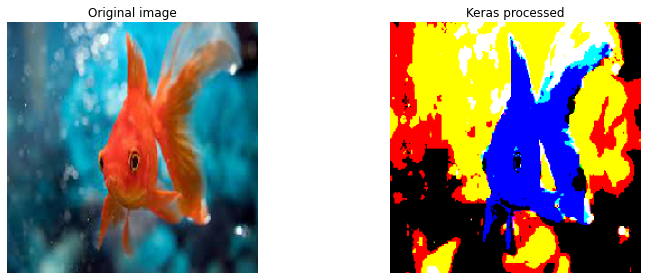

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
brown_bear (99.16%)


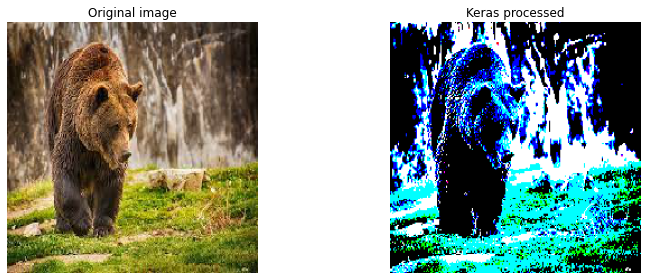

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
collie (26.31%)


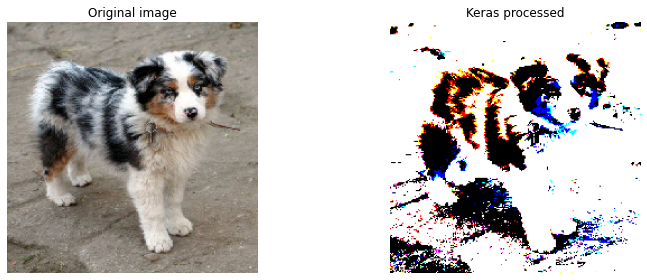

In [7]:
from keras.applications.vgg16 import decode_predictions

def retrieve_class(image):
  labels = decode_predictions(model.predict(preprocess_input(image.reshape(1, 224, 224, 3))))
  label = labels[0][0]
  print('%s (%.2f%%)' % (label[1], label[2]*100))

image_titles = ['Original image', 'Keras processed']

for image in images:
  retrieve_class(image)
  imgs = np.asarray([image, preprocess_input(image)])
  f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
  ax[0].imshow(image)
  ax[0].axis('off')
  ax[0].set_title(image_titles[0])
  ax[1].imshow(preprocess_input(image))
  ax[1].axis('off')
  ax[1].set_title(image_titles[1])
  plt.tight_layout()
  plt.show()
  print(" ")

We can see model is just perfect. We can watch what the models uses as input on the correct format vs the real image. On the commented dictionary above we have the correct strings that this model is able to identify due to its 1000 neurons on the last layer.

### 1.1.- Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Here, we create and use ReplaceToLinear instance.
I do not understand well this part yet. Let us see if I find the explanation later. To better understand its effect I will change the function a bit with the possibility to introduce the layer to be studied as a parameter and leaving the last one by default.

In [8]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model, layer: int = -1):
    cloned_model.layers[layer].activation = tf.keras.activations.linear

In [29]:
img1 = load_img('images/fish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/dog.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])


image = images[0]

labels = decode_predictions(model.predict(preprocess_input(image.reshape(1, 224, 224, 3))))
label = labels[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

goldfish (99.96%)


In [32]:
decode_predictions(model.predict(preprocess_input(image.reshape(1, 224, 224, 3))))

[[('n01443537', 'goldfish', 0.99955446),
  ('n02606052', 'rock_beauty', 0.00029088816),
  ('n01632777', 'axolotl', 5.9080496e-05),
  ('n09256479', 'coral_reef', 3.615388e-05),
  ('n02607072', 'anemone_fish', 1.1298357e-05)]]

In [9]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 294, 413])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

## 2.- Vanilla Saliency
Saliency generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.


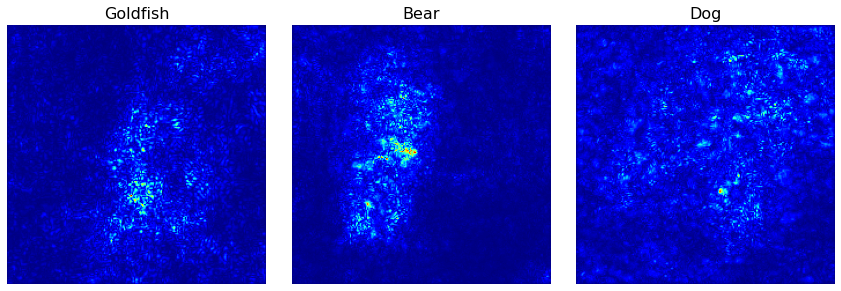

In [10]:
# %%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

image_titles = ['Goldfish', 'Bear', 'Dog']

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In order to understand if there are differences between layers let us study what layers does VGG16 own. On previous notebooks I show that with a higher number of filters the net learns little details
and on the contrary it learns bigger features.


I have figured out that we are always showing the last layer results, since we are changing just an activation function but not choosing the layer to study. This is not the case for the next models to study.

As we can see, features size does not seem to change although the region indeed does. This is why we are not selecting the layer we want to study.
These changes I think must be applied on the original saliency script. 


## 3.- SmoothGrad

As you can see above, Vanilla Saliency map is too noisy, so let's remove noise in the saliency map using SmoothGrad! SmoothGrad is a method that reduce the noise including saliency map by adding noise to input image.

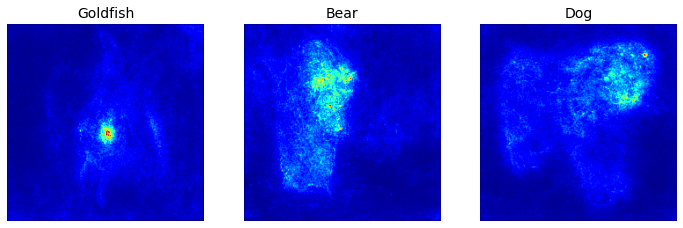

CPU times: user 1.41 s, sys: 27 ms, total: 1.44 s
Wall time: 1.65 s


In [11]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                      smooth_noise=0.20, ) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')


plt.show()


## 4.- GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).


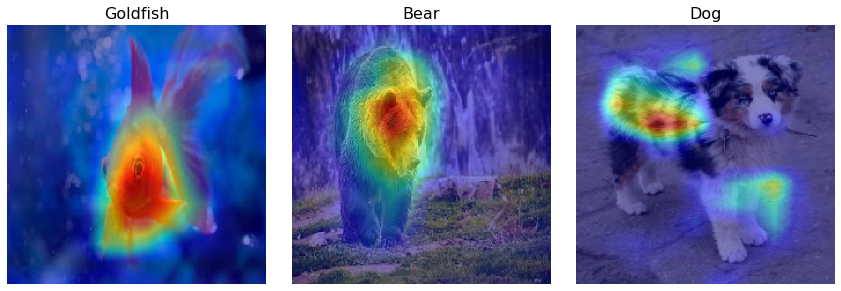

CPU times: user 1.05 s, sys: 168 ms, total: 1.22 s
Wall time: 1.11 s


In [12]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

As I have suggested as an idea on a previous cell it would be nice in terms of explainability to understand what is happening between different layers. After asking this issue to the repo owners
I have figured out they had already thought about this and they have implemented this idea.

The only requirement is that it has to be a conv layer. If I select 2 layers from VGG model we can check that the first conv layer has 64 filters and the seventh layer has 256 so the features learnt by this last layer should be much smaller. 

To visualize gradcam needs the output values of and the gradient with respect to the layer.
On the other hand, to visualize saliency map need the gradient with respect to model input.
That's, Saliency does NOT need the information about the intermediate layer.

In [13]:
#model.layers
model.layers[1], model.layers[7]

(<tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9c4016bfd0>,
 <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9c400c9e10>)

 Effects for the 1st layer


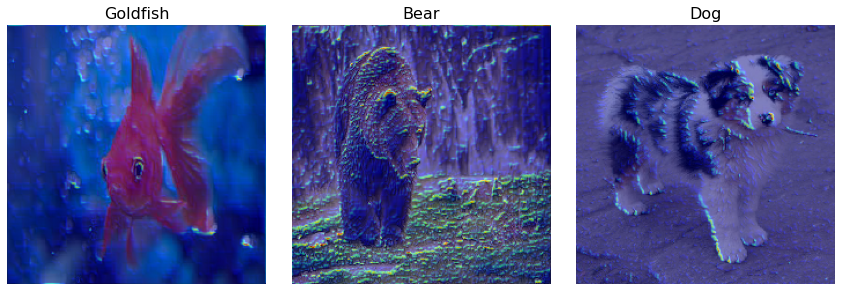

 Effects for the 7th layer


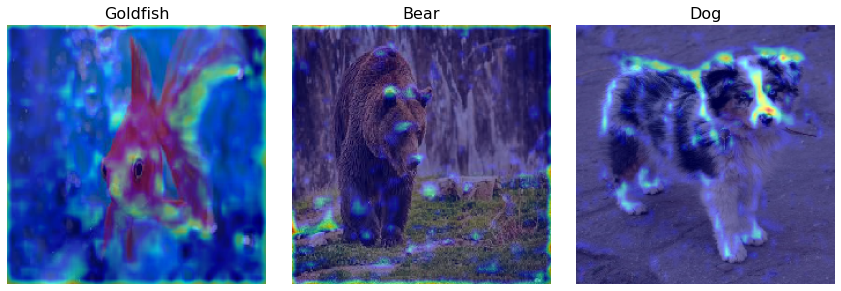

In [14]:
print(" Effects for the 1st layer")
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                clone=True)
cam = gradcam(score,
              X,
              penultimate_layer=1)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

print(" Effects for the 7th layer")
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                clone=True)
cam = gradcam(score,
              X,
              penultimate_layer=7)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

I am not sure about if my assumptions are correct. Anyway, this issue is a very worthy research path for future works.



As you can see above, GradCAM is useful method for intuitively knowing where the attention is. However, when you take a look closely, you'll see that the visualized attentions don't completely cover the target.
This is the case and the bear that do not seem to work too well.

Okay then, let's move on to next method that is able to fix the problem above you looked.


## 5.- GradCAM++


GradCAM++ can provide better visual explanations of CNN model predictions.

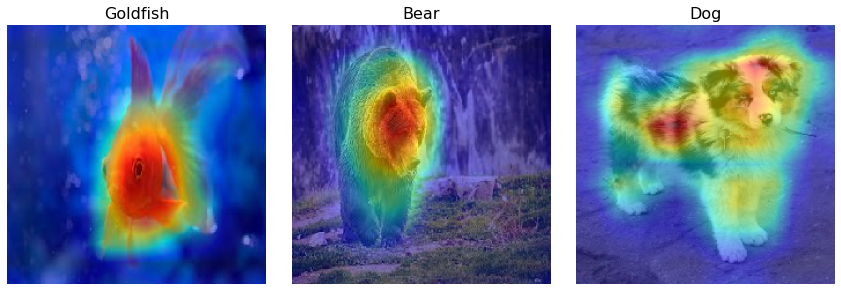

CPU times: user 1.08 s, sys: 128 ms, total: 1.21 s
Wall time: 1.1 s


In [15]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


## 6.- ScoreCAM

Now let us look at ScoreCAM. It is an another method that generates Class Activation Map. The characteristic of this method is that it's the gradient-free method unlike GradCAM, GradCAM++ or Saliency.


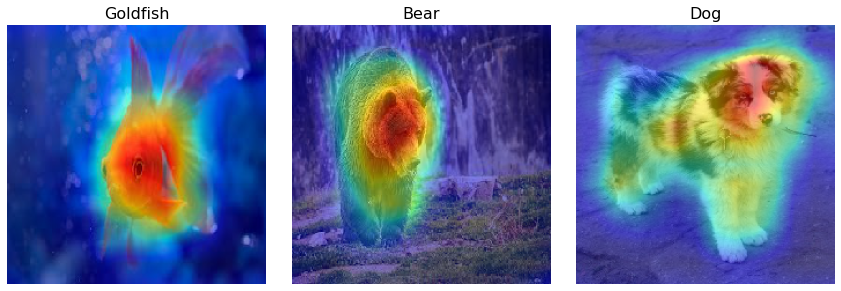

CPU times: user 24.1 s, sys: 831 ms, total: 24.9 s
Wall time: 24.3 s


In [16]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

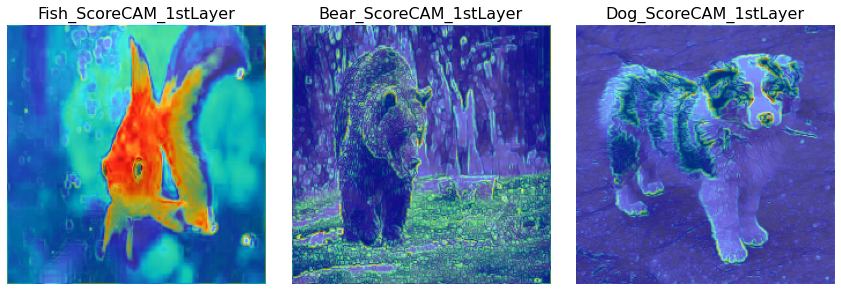

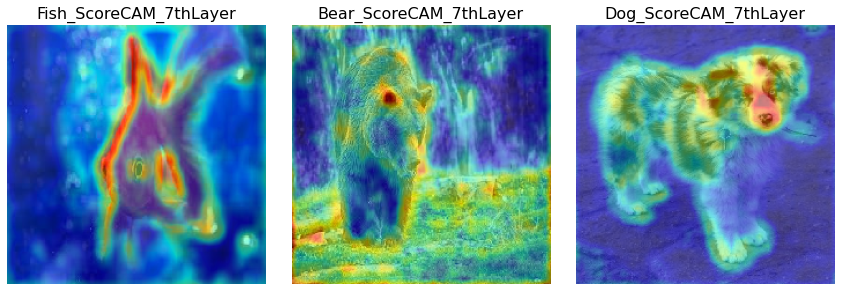

In [17]:
scorecam = Scorecam(model)
image_titles = ['Fish_ScoreCAM_1stLayer', 'Bear_ScoreCAM_1stLayer', 'Dog_ScoreCAM_1stLayer']
cam = scorecam(score, X, penultimate_layer=1)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

image_titles = ['Fish_ScoreCAM_7thLayer', 'Bear_ScoreCAM_7thLayer', 'Dog_ScoreCAM_7thLayer']
cam = scorecam(score, X, penultimate_layer=7)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

This method of explainability is a bit worse as we can see from the results of the dog. The biggest difference between ScoreCAM and GradCAMs is whether it needs the gradient calculation.

## 7.- Faster Score-Cam


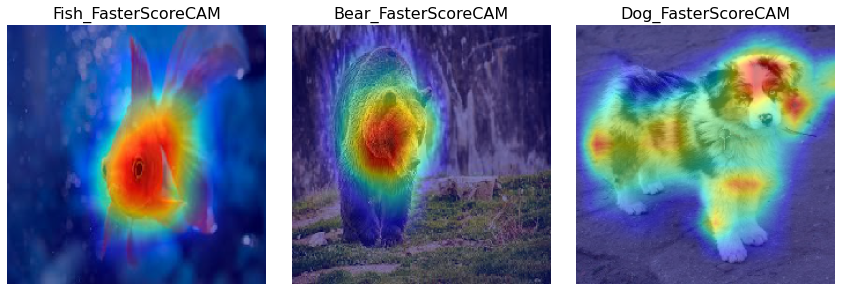

CPU times: user 4.8 s, sys: 152 ms, total: 4.95 s
Wall time: 4.8 s


In [18]:
%%time
image_titles = ['Fish_FasterScoreCAM', 'Bear_FasterScoreCAM', 'Dog_FasterScoreCAM']
from tf_keras_vis.scorecam import Scorecam

scorecam = Scorecam(model, model_modifier=replace2linear)


cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


## 8.- All Together.

Let us use 3 different photos to check all the applicabble methods at once

In [19]:
def retrieve_class(image):
  labels = decode_predictions(model.predict(preprocess_input(np.asarray(image).reshape(1, 224, 224, 3))))
  label = labels[0][0]
  print('%s (%.2f%%)' % (label[1], label[2]*100))



retrieve_class(load_img('images/cheetah.jpg', target_size=(224, 224)))

cheetah (99.84%)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cheetah (99.84%)


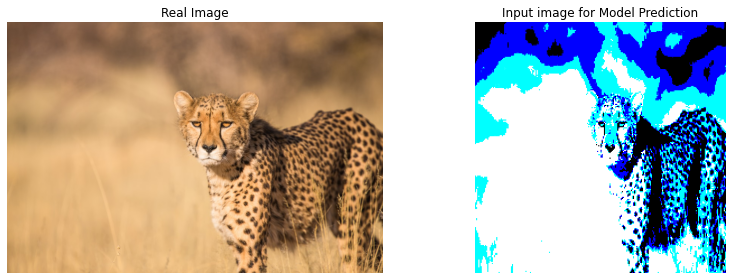

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
English_foxhound (32.41%)


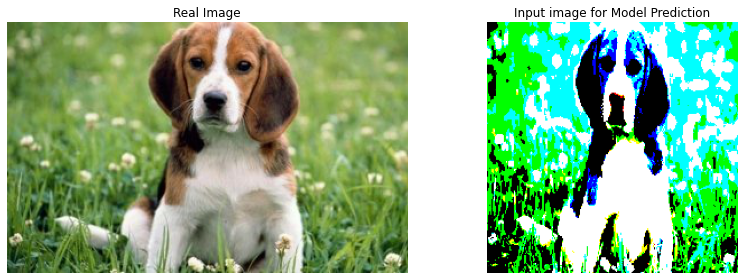

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
hammerhead (59.18%)


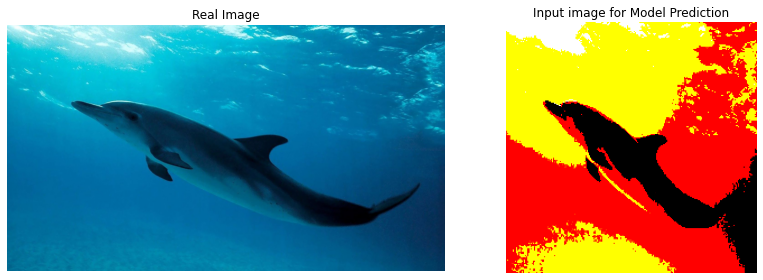

In [20]:
image_titles = ['Real Image', 'Input image for Model Prediction']

# Load images and Convert them to a Numpy array
img1 = load_img('images/cheetah.jpg', target_size=(224, 224))
img2 = load_img('images/beagle.jpg', target_size=(224, 224))
img3 = load_img('images/dolphin.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

img11, img22, img33 = load_img('images/cheetah.jpg'), load_img('images/beagle.jpg') , load_img('images/dolphin.jpg')
images_original = np.asarray([np.array(img11), np.array(img22), np.array(img33)])

for index, image in enumerate(images_original):
  image1 = images[index]
  retrieve_class(image1)
  imgs = np.asarray([image, preprocess_input(image1)])
  f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
  ax[0].imshow(imgs[0])
  ax[0].axis('off')
  ax[0].set_title(image_titles[0])
  ax[1].imshow(imgs[1])
  ax[1].axis('off')
  ax[1].set_title(image_titles[1])
  plt.tight_layout()
  plt.show()
  print(" ")

In [21]:
indexes = list()

for index, element in enumerate(d.values()):
  if element[1] == 'beagle' or element[1] == 'English_foxhound' or element[1] == 'hammerhead':
    indexes.append(index)
indexes

[4, 162, 167]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


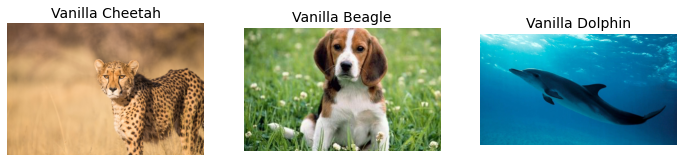

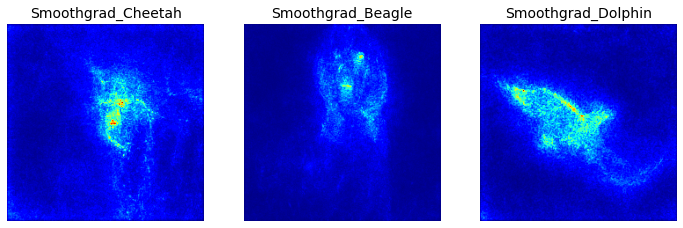

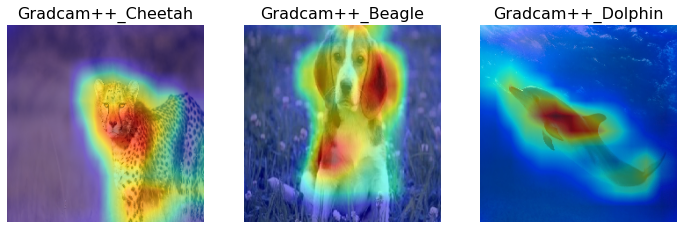

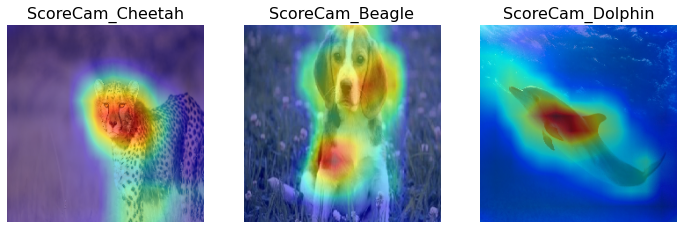

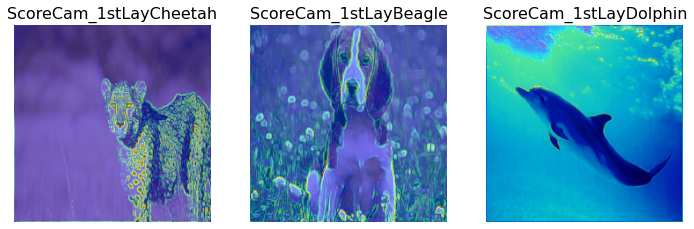

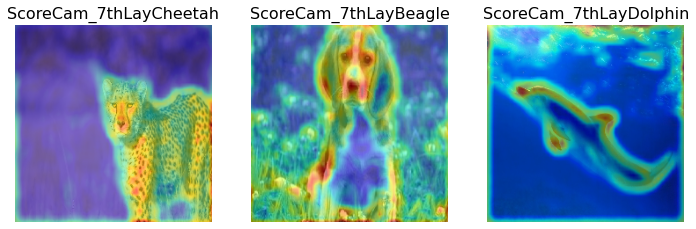

In [22]:
import time

images_original = np.asarray([np.array(img11), np.array(img22), np.array(img33)])
image_titles = ['Vanilla Cheetah', 'Vanilla Beagle', 'Vanilla Dolphin']
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images_original[i], cmap='jet')
    ax[i].axis('off')
plt.show()
time.sleep(2)

X = preprocess_input(images)

image_titles1 = ['Cheetah', 'Beagle', 'Dolphin']
## SMOOTHGRAD
score = CategoricalScore(indexes)
saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20) 
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
image_titles = ['Smoothgrad_' + title for title in image_titles1]
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.show()

time.sleep(2)
image_titles = ['Gradcam++_' + title for title in image_titles1]
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
cam = gradcam(score,
              X,
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.show()
time.sleep(2)

## SCORECAM
image_titles = ['ScoreCam_' + title for title in image_titles1]
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')

plt.show()


image_titles = ['ScoreCam_1stLay' + title for title in image_titles1]
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')

plt.show()

image_titles = ['ScoreCam_7thLay' + title for title in image_titles1]
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=7)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')

plt.show()

## 9.- Conclussions

I have tested the library to visualize salienzy and explain a bit how they work. We have shown that it is possible to visualize not only the last layer. Gradcam++ and ScoreCam seem to be 
the most reliable methods, but the last one is a bit slow. The solution for this last issue is to use Faster Score Cam.